## import

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
import torch
import os
from collections import Counter
import sklearn
import psutil
import numpy as np
import time
from loguru import logger

import pandas as pd
# import scanpy as sc
from tqdm import tqdm
import random
import sys
import multiprocessing
import anndata as ad
import gc
import pickle
# from torch.nn.utils.rnn import pad_sequence

root_path = os.path.abspath('/home/chenyx/scMulan/cellgpt_v1/')
sys.path.append(os.path.abspath(root_path))

# from imp import reload
# reload(hf_tokenizer) # also reload(mymodule)

# from utils.hf_tokenizer import cellGenesisTokenizer

data_root_path = '/home/bianhaiyang/tmp_dataHub/datasets/'
dataset = 'ECA_GO'
dataPath = os.path.join(data_root_path,dataset)
assert os.path.exists(dataPath)
tmp_dataPath = os.path.join(dataPath,'tmp_files')

In [4]:
from utils.hf_tokenizer import cellGenesisTokenizer

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from model.model import GPTConfig, cellGPTModel
import torch.nn.functional as F
from model import model_kvcache

In [6]:
meta_info = torch.load(os.path.join(dataPath,'meta_info.pt'))
chars = meta_info['token_set']
tokenizer = cellGenesisTokenizer(chars)

In [7]:
n_express_level = 10

In [8]:
from multiprocessing import Pool
import multiprocessing
from tools.generation.denovoGeneration import generate_denovo

# Init

In [9]:
import scanpy as sc
import matplotlib.pyplot as plt

In [10]:
def generate_prompt_for_cg(idx,meta_data,meta_pool):
    meta_num = torch.randint(0,len(meta_pool),(1,)).item()
    task_cols = meta_pool[meta_num]
    metadata_series = meta_data.loc[idx, task_cols]
    metadata_list = metadata_series.tolist()
    while 'Unclassified' in metadata_list:
        meta_num = torch.randint(0,len(meta_pool),(1,)).item()
        task_cols = meta_pool[meta_num]
        metadata_series = meta_data.loc[idx, task_cols]
        metadata_list = metadata_series.tolist()
    return metadata_list

In [11]:
def get_binned_expression(row,n_expression_level):
    max_expr = row.max()
    bins = np.linspace(0, max_expr, n_expression_level + 1) # 生成10个bin的边界，所以是11个值 (n+1)
    binned_expr = np.digitize(row, bins, right=True) 
    return pd.Series(binned_expr/n_expression_level, index=row.index)

In [12]:
def convert_cellsentence_ele_to_df(cellGene_ele, n_expression_level, task = 'cs'):
    dfList = []
    ## fetch gene expression
    for c,e in tqdm(cellGene_ele):
        st = c.index(2207)+1
        c_list = tokenizer.convert_ids_to_tokens(c[st:-1])
        ele = e[st:-1]
        dfDict = {}
        for name,ele in zip(c_list,ele):
            dfDict[name] = ele/n_expression_level
        dfList.append(dfDict)
    gDF = pd.DataFrame(dfList).fillna(0)
    return gDF

### load model

In [13]:
from model.model import GPTConfig, cellGPTModel
import torch.nn.functional as F
from model.model_kvcache import cellGPTModel_kv

In [14]:
ckp = torch.load('/nfs/public/cell_gpt_data/dataHub/datasets/datasets/ECA_GO/model_hub/ckpt245000.pt')
gptconf = GPTConfig(**ckp['model_args'])
model_kv = cellGPTModel_kv(gptconf)
model_kv = model_kv.cuda()
model_kv.load_state_dict(ckp['model'])
model_kv.eval()

2024-06-23 23:37:36.196 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2024-06-23 23:37:42.767 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M


cellGPTModel_kv(
  (transformer): ModuleDict(
    (wte): Embedding(2222, 1120)
    (wee): Embedding(11, 1120)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=1120, out_features=3360, bias=False)
          (c_proj): Linear(in_features=1120, out_features=1120, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=1120, out_features=4480, bias=False)
          (c_proj): Linear(in_features=4480, out_features=1120, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=1120, out_features=2222, bias=False)
  (epx_head): Linear(in_features=1120, out_features=2222, bias=False)
  (criterion): Masked

### generation

In [15]:
def pack_arg(arg,n_process):
    return [arg for _ in range(n_process)]

In [16]:
celltype_list = ['Cardiomyocyte cell', "Smooth muscle cell", "Pericyte", "Vascular endothelial cell", "Lymphatic endothelial cell", 'Neuron', 'Fibroblast', 'Macrophage', "T cell", 'B cell', 'Adipocyte', "Monocyte"]
age_list = ["20 year", "25 year", "30 year", "35 year", "40 year", "45 year", "50 year", "55 year", "60 year", "65 year",  "70 year", "75 year", "80 year"]
gender_list = ["M", "F"]

In [17]:
combinations = []
for a in age_list:
    for g in gender_list:
        for ct in celltype_list:
            condition_dict = {'Heart': 0, ct: 0, a:0, g:0, '<SPToken1>': 0}
            combinations.append(condition_dict)

In [18]:
repeat_n =  100
repeated_combinations = combinations*repeat_n
len(repeated_combinations)

31200

In [19]:
if __name__ == '__main__': 
    multiprocessing.set_start_method('spawn', force=True)
    print('当前母进程: {}'.format(os.getpid()))
    start = time.time()
    gamma = 0.1 # 控制生成长度（作用也不是特别大，一般是0.1），其实是在生成中，对<E>这个logit的加权
    use_gpu_device = [0, 1, 2, 3] # 用哪几块GPU，越多越好，大概是每块10G显存。
    n_process_in_each_gpu = 3 # 每个GPU上并行几个，默认是2；
    ckp_path = '/nfs/public/cell_gpt_data/dataHub/datasets/datasets/ECA_GO/model_hub/ckpt245000.pt' # 模型地址
    results_dir = f'/nfs/public/cell_gpt_data/dataHub/generated_cells/Heart_aging/' # 存储文件地址，需要改名；会自动新建最后一个文件夹

    world_size = len(use_gpu_device)
    n_process = n_process_in_each_gpu * world_size
    process_idx = list(range(n_process))
    devices = [device for device in use_gpu_device for _ in range(n_process_in_each_gpu)]    
    print("devices: ",devices)

    if not os.path.exists(results_dir):
        os.mkdir(results_dir)
    results_save_dir = results_dir + 'generate_01gamma_' ## 随便给个Note记一下参数之类的
    # meta_data_organ = meta_sub_heart
    meta_data_organ = None

    idxs = np.array_split(repeated_combinations, n_process) # 这里的idxs其实不规范，给的是生成条件，而不是真的index
    idxs = [list(idx) for idx in idxs]


    gammas = pack_arg(gamma,n_process)
    # 不抽metadata，直接把meta_term改成自己想要的数值，也就是指定的organ和cell type
    force_meta = pack_arg(True, n_process) 

    meta_terms = pack_arg(
         None
        ,n_process)

    # meta_terms = pack_arg(['organ','cell_type'],n_process) # 如果不force的话
    meta_organs = pack_arg(meta_data_organ,n_process)

    ckp_paths = pack_arg(ckp_path,n_process)
    results_save_dirs = [results_save_dir+str(process_id)+'results.pt' for _,process_id in zip(devices,process_idx)]

    args = [(idx, device, gamma, meta_organ, ckp_path, save_path, meta_term, force) \
            for idx, device, gamma, meta_organ,ckp_path,save_path,meta_term, force in \
            zip(idxs, devices,gammas, meta_organs, ckp_paths,results_save_dirs,meta_terms, force_meta)]
    # 创建进程池
    with Pool(n_process) as pool:
        # 使用pool.map并行处理
        pool.map(generate_denovo.generate, args)

    end = time.time()
    print("Generation Finished, 总共用时{}秒".format((end - start)))

当前母进程: 3951372
devices:  [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]


2024-06-23 23:38:53.540 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2024-06-23 23:38:53.597 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2024-06-23 23:38:54.358 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2024-06-23 23:38:54.531 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2024-06-23 23:38:54.605 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2024-06-23 23:38:54.692 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2024-06-23 23:38:54.758 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2024-06-23 23:38:54.849 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2024-06-23 23:38:54.943 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2024-06-23 23:38:55.009 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2024-06-23 23:38:55.048 | INFO     | model.model_k

当前子进程: 3952837
当前子进程: 3952848


  0%|          | 0/2600 [00:00<?, ?it/s]2024-06-23 23:39:00.444 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M
2024-06-23 23:39:00.633 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M


当前子进程: 3952839


  0%|          | 1/2600 [00:00<32:31,  1.33it/s]2024-06-23 23:39:00.765 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M
2024-06-23 23:39:00.814 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M


当前子进程: 3952841
当前子进程: 3952849
当前子进程: 3952843


  0%|          | 0/2600 [00:00<?, ?it/s]2024-06-23 23:39:00.942 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M
2024-06-23 23:39:00.944 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M
  0%|          | 0/2600 [00:00<?, ?it/s].04s/it]

当前子进程: 3952846
当前子进程: 3952847


  0%|          | 0/2600 [00:00<?, ?it/s]2024-06-23 23:39:01.340 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M


当前子进程: 3952844


  0%|          | 1/2600 [00:02<1:26:59,  2.01s/it]

当前子进程: 3952845


2024-06-23 23:39:03.344 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M
  0%|          | 0/2600 [00:00<?, ?it/s].33s/it]  

当前子进程: 3952842


  0%|          | 0/2600 [00:00<?, ?it/s] 1.50s/it]

当前子进程: 3952840


100%|██████████| 2600/2600 [1:32:55<00:00,  2.14s/it]


Generation Finished, 总共用时5598.848963737488秒


# Proprocess generated data

### set functions

In [20]:
import tools.generation.convert_generation_to_gdata as cgdata

In [21]:
def get_binned_expression(row,n_expression_level):
    max_expr = row.max()
    bins = np.linspace(0, max_expr, n_expression_level + 1) # 生成10个bin的边界，所以是11个值 (n+1)
    binned_expr = np.digitize(row, bins, right=True) 
    return pd.Series(binned_expr/n_expression_level, index=row.index)

def convert_cellsentence_ele_to_df(cellGene_ele, n_expression_level, task = 'cs'):
    dfList = []
    ## fetch gene expression
    for c,e in tqdm(cellGene_ele):
        st = c.index(2207)+1
        c_list = tokenizer.convert_ids_to_tokens(c[st:-1])
        ele = e[st:-1]
        dfDict = {}
        for name,ele in zip(c_list,ele):
            dfDict[name] = ele/n_expression_level
        dfList.append(dfDict)
    gDF = pd.DataFrame(dfList).fillna(0)
    return gDF

In [22]:
def format_generation_to_adata(generation_path,cell_type):
    results_save_dirs = [generation_path+res_p for res_p in os.listdir(generation_path)]
    results_save_dirs.sort()
    logger.info('working path is',generation_path)
    all_results = {'idx': [], 'cgg': [], 'cge': []}
    
    logger.info('building dataframe')
    for path in tqdm(results_save_dirs):
        # 加载结果
        results = torch.load(path)
        # 将每个结果文件的内容添加到all_results字典
        for key, value in results.items():
            all_results[key].extend(value)
    
    cgg = all_results['cgg']
    cge = all_results['cge']
    
    gg_len = []
    for gg in cgg:
        gg_len.append(len(gg))
    plt.hist(np.array(gg_len),bins=50,)
    
    gDF = convert_cellsentence_ele_to_df(zip(cgg,cge),n_express_level)
    origin_columns = list(meta_info['gene_set'])
    missing_columns = list(set(origin_columns) - set(gDF.columns))
    logger.debug(f'missing column number is {len(missing_columns)}')
    missing_columns_data = pd.DataFrame(0, columns=missing_columns, index=gDF.index)
    gDF = pd.concat([gDF, missing_columns_data], axis=1)
    gDF = gDF.reindex(columns=origin_columns)
    gDF.index = gDF.index.astype(str) + '_generated'
    gDF = sc.AnnData(gDF.astype(float))
    gDF.obs['cell_type'] = cell_type
    return gDF

2024-06-24 01:12:01.555 | INFO     | tools.generation.convert_generation_to_gdata:format_generated_dict_to_adata:42 - working path is
2024-06-24 01:12:01.557 | INFO     | tools.generation.convert_generation_to_gdata:format_generated_dict_to_adata:45 - building dataframe
100%|██████████| 31200/31200 [00:00<00:00, 39974.56it/s]
2024-06-24 01:12:10.727 | DEBUG    | tools.generation.convert_generation_to_gdata:format_generated_dict_to_adata:64 - missing column number is 352


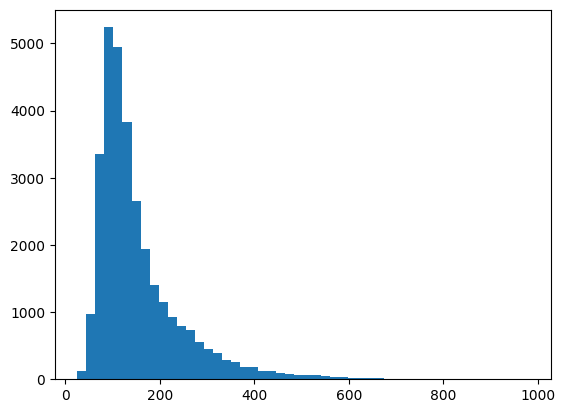

In [23]:
generated_path = f'/nfs/public/cell_gpt_data/dataHub/generated_cells/Heart_aging/'
adata_generated,idxs = cgdata.format_generated_dict_to_adata(generation_path = generated_path,
                                     cell_type = "NA", # 生成的细胞类型
                                     n_express_level = n_express_level,
                                     meta_info = meta_info,
                                     tokenizer = tokenizer,
                                     rename_index = False)

In [24]:
adata_generated

AnnData object with n_obs × n_vars = 31200 × 2000
    obs: 'cell_type'

In [25]:
adata_generated.obs['age'] = ""
adata_generated.obs['gender'] = ""

In [26]:
adata_generated.obs.loc[:,['cell_type', 'age', 'gender']] = np.array([list(x.keys())[1:4] for x in repeated_combinations])

In [27]:
adata_generated.write_h5ad("/nfs/public/cell_gpt_data/dataHub/generated_cells/Heart_aging/merged.h5ad")